In [2]:
using Plots
using LaTeXStrings
using LinearAlgebra
using PrettyTables
using Printf
using DifferentialEquations

### 1. Forward Euler Method
#### 1.1 Numerical Scheme
Given a IVP $u' = f(t,u), u(a) = u_0$, and the a finite collection of nodes defined by
$$
t_i = a + ih, \quad h = \frac{b-a}{n}, \quad i = 0, \cdots, n,
$$
iteratively compute the sequence
$$
u_{i+1}  = u_{i} + h f(t_i, u_{i}), \quad i = 0, \cdots, n-1.
$$
Then $u_i$ is approximately the value of the solution at $t = t_i$.

In [38]:
function euler(ivp, n)
    # Time discretization
    a, b = ivp.tspan
    h = (b-a)/n
    t = [a + i*h for i in 0:n]

    # Initial condition and output setup.
    u = fill(float(ivp.u0), n+1)
    
    # The time stepping iteration.
    for i in 1:n
        u[i+1] = u[i] + h*ivp.f(u[i], ivp.p, t[i])
    end

    return t, u
end


euler (generic function with 1 method)

#### 1.2 Example
##### 1.2.1 Example 1
We consider the IVP $u'=\sin[(u+t)^2]$ over $0\leq t \leq 4$, with $u(0) = -1$.

In [19]:
f = (u, p, t) -> sin((t+u)^2);

tspan = (0.0, 4.0);

u0 = -1.0;

ivp = ODEProblem(f, u0, tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 4.0)
u0: -1.0

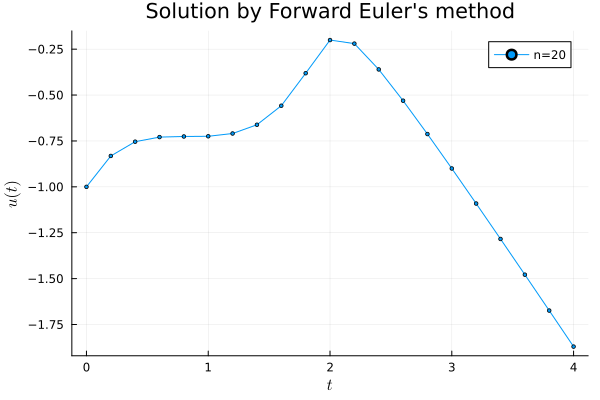

In [20]:
t, u = euler(ivp, 20)

plot(t, u, m=2, label="n=20", 
xlabel = L"t", ylabel=L"u(t)", title = "Solution by Forward Euler's method")

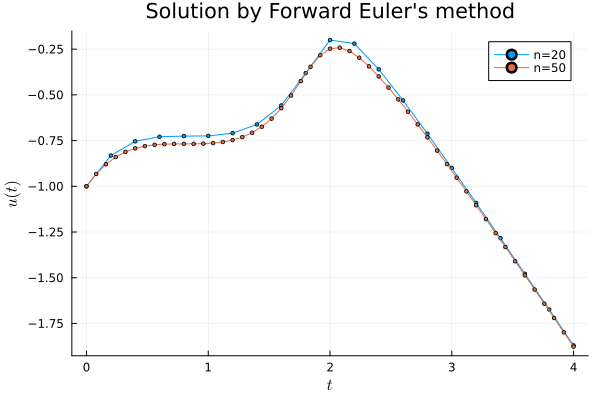

In [21]:
t,u = euler(ivp,50)
plot!(t,u,m=2,label="n=50")

##### 1.2.2 Example 2
Given the IVP
$$
u' = 2(1+t)(1+u^2), \ 0 \le t \le 0.5, \ u(0) = 0,  \ \hat{u}(t) = \tan(2t + t^2)
$$

- (1) Plot the solution for $n = 320$.
- (2) For $ n = 10*2^k, k = 2, 3, \cdots, 10$, compute the error at the final time and make a log-log convergence plot, including a reference line for first-order convergence.

In [22]:
f = (u, p, t) ->  2*(1+t)*(1+u^2);

# x = 2 
tspan = (0.0, 0.5);

u₀ = 0;

ivp = ODEProblem(f, u₀, tspan)

ODEProblem with uType Int64 and tType Float64. In-place: false
timespan: (0.0, 0.5)
u0: 0

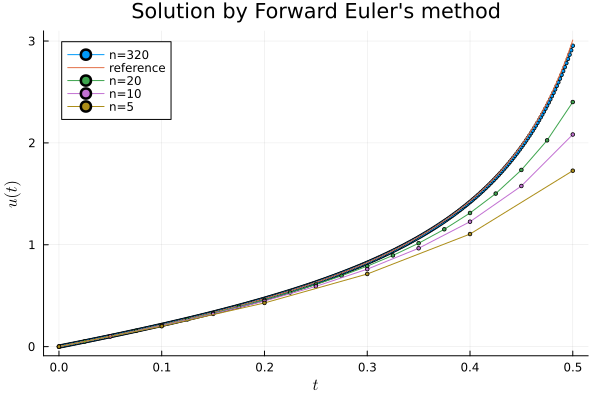

In [23]:
t, u = euler(ivp, 320);

# Plot solution when n = 30
plot(t, u, m=2, label="n=320", 
xlabel = L"t", ylabel=L"u(t)", title = "Solution by Forward Euler's method")

# Plot the reference solution
plot!(t, t->tan(2*t + t^2), label="reference")

# Plot solution when n = 20
t, u = euler(ivp, 20);
plot!(t, u, m=2, label="n=20")

# Plot solution when n = 10
t, u = euler(ivp, 10);
plot!(t, u, m = 2, label="n=10")

# Plot solution when n = 5
t, u = euler(ivp, 5);
plot!(t, u, m = 2, label="n=5")

In [24]:
n = [10 * 2^k for k in 2:10];
err = [];

for n in n
    t, u = euler(ivp, n);
    u_exact = x->tan(2*x + x^2);
    push!(err, norm(u_exact.(t)-u, Inf) )
end

pretty_table([n err]; header=["n", "Inf-norm error"]) # different from the FNC book at https://tobydriscoll.net/fnc-julia/ivp/euler.html

┌───────┬────────────────┐
│     n │ Inf-norm error │
├───────┼────────────────┤
│    40 │       0.364496 │
│    80 │       0.203266 │
│   160 │       0.108037 │
│   320 │      0.0558052 │
│   640 │      0.0283761 │
│  1280 │        0.01431 │
│  2560 │     0.00718596 │
│  5120 │     0.00360078 │
│ 10240 │     0.00180235 │
└───────┴────────────────┘


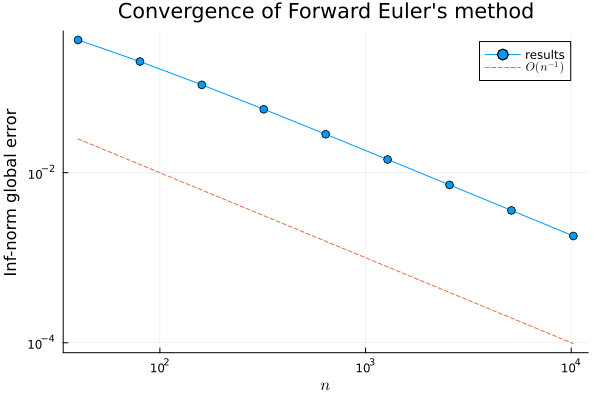

In [25]:
plot(n,err,m=:o,label="results", 
    xaxis=(:log10,L"n"), yaxis=(:log10,"Inf-norm global error"),
    title="Convergence of Forward Euler's method")

# Add line for the perfect 1st order.
plot!(n, 1*(n).^(-1), l=:dash, label=L"O(n^{-1})")

### 2. Backward Euler Method
#### 2.1 Numerical Scheme
The backward Euler method computes the approximation using
$$
u_{i+1} = u_i + hf(t_{i+1}, u_{i+1}).
$$
This differs from the (forward) Euler method in that the forward method uses $f(t_i, u_i)$ in place of $f(t_{i+1}, u_{i+1})$. The backward Euler method is an implicit method: the new approximation $u_{i+1}$ appears on both sides of the equation, and thus the method needs to solve an algebraic equation for the unknown $u_{k+1}$. (can be done with fixed-iteration for non-stiff problems, or Newton-Raphson method).



In [26]:
# Reference: https://www.mathworks.com/matlabcentral/answers/1716860-using-implicit-euler-method-with-newton-raphson-method

function imp_euler(ivp, n, f, f_u, tol, N) # tol(errors), N(iterations) is for the Newton-Raphson iteration.
    # Time discretization
    a, b = ivp.tspan
    h = (b-a)/n
    t = [a + i*h for i in 0:n]

    # Initial condition and output setup.
    u = fill(float(ivp.u0), n+1)
    
    # The time stepping iteration.
    for i in 1:n
        g = z -> z - u[i] - h*f(z, ivp.p, t[i+1])
        g_u = z -> 1 - h*f_u(z, ivp.p, t[i+1])
        u[i+1] = newton(g, g_u, u[i], tol, N) # Newton-Raphson root finding
    end

    return t, u
end

function newton(f, fp, x0, tol, N) # find the root of f(x) = 0, with the maximum iterations N and tolerence tol.
    i = 0
    fc = abs(f(x0))

    while fc > tol
        xc = x0 - (f(x0)/fp(x0))
        fc = abs(f(xc))
        x0 = xc
        i = i+1
        if (i > N)
            println("Methods failed after $i iterations")
            break
        end
    end
    return x0
end

newton (generic function with 1 method)

#### 2.2 Example
##### 2.2.1 Example 1
We consider the IVP $u'=\sin[(u+t)^2]$ over $0\leq t \leq 4$, with $u(0) = -1$.


In [27]:
f = (u, p, t) -> sin((t+u)^2);
f_u = (u, p, t) -> 2*(t+u)*cos((t+u)^2);
tspan = (0.0, 4.0);
u0 = -1.0;

ivp = ODEProblem(f, u0, tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 4.0)
u0: -1.0

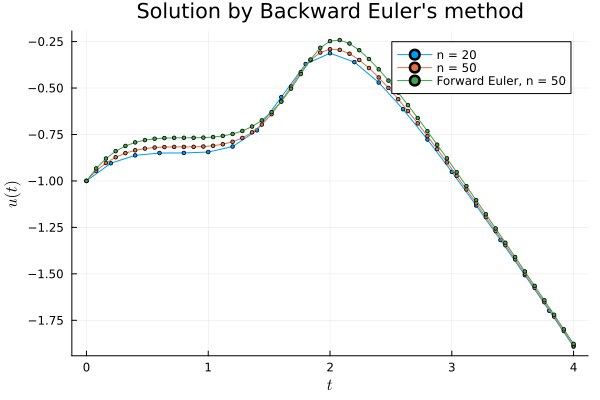

In [28]:
n = 20;
tol = 1e-4;
N = 1e3;

t, u = imp_euler(ivp, n, f, f_u, tol, N);
plot(t, u, m=2, label="n = 20", 
xlabel = L"t", ylabel=L"u(t)", title = "Solution by Backward Euler's method")

n = 50;
t, u = imp_euler(ivp, n, f, f_u, tol, N);
plot!(t, u, m=2, label="n = 50")

t, u = euler(ivp, n);
plot!(t, u, m=2, label="Forward Euler, n = 50")

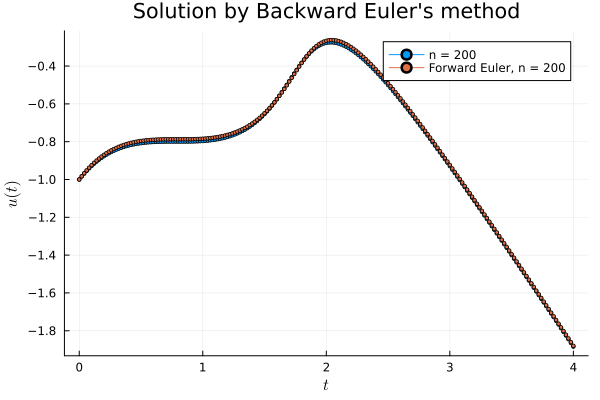

In [29]:
n = 200;

tol = 1e-4;
N = 1e3;

t, u = imp_euler(ivp, n, f, f_u, tol, N);
plot(t, u, m=2, label="n = 200", 
xlabel = L"t", ylabel=L"u(t)", title = "Solution by Backward Euler's method")


t, u = euler(ivp, n);
plot!(t, u, m=2, label="Forward Euler, n = 200")

##### 2.2.2 An example with stiff equation 
Reference: https://people.sc.fsu.edu/~jburkardt/classes/math1090_2020/implicit/implicit.pdf

Consider the following differential equation, which we will give the nickname “stiff ”:
$$
\begin{aligned}
& y^{\prime}=50(\cos (t)-y) \\
& y(0.0)=0.0
\end{aligned}
$$
for which the exact solution is
$$
y(t)=50 \frac{\sin (t)+50 \cos (t)-50 e^{-50 t}}{2501}
$$
and suppose we want estimate the solution over the interval $[0, 1]$ using the Euler method.

In [30]:
# Solve with Forward Euler
f = (u, p, t) -> 50*(cos(t) - u);
f_u = (u, p, t) -> -50;
f_exact = t -> 50*((sin(t)+50*cos(t)-50*exp(-50*t))/2501);

tspan = (0.0, 1.0);
u0 = 0;

ivp = ODEProblem(f, u0, tspan)


ODEProblem with uType Int64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0

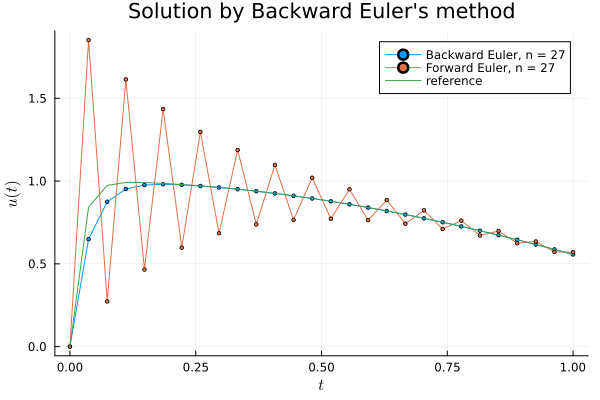

In [31]:
n = 27;

tol = 1e-4;
N = 1e3;

t, u = imp_euler(ivp, n, f, f_u, tol, N);
plot(t, u, m=2, label="Backward Euler, n = 27", 
xlabel = L"t", ylabel=L"u(t)", title = "Solution by Backward Euler's method")

t, u = euler(ivp, n);
plot!(t, u, m=2, label="Forward Euler, n = 27")

# Plot the reference solution
plot!(t, f_exact, label="reference")



### 3. Improved Euler Method
#### 3.1 Numerical Scheme
The improved Euler method is the one-step formula
$$
{u}_{i+1} = u_i +  hf\left(t_i+\tfrac{1}{2}h,u_i+\tfrac{1}{2}h f(t_i,u_i)\right).
$$
whose local truncation error is $\tau_{i+1} = \mathcal{O} (n^2)$.

In [43]:
# Implementation of Improved Euler
# Copied from https://tobydriscoll.net/fnc-julia/ivp/rk.html

"""
    ie2(ivp, n)

Apply the Improved Euler method to solve the given IVP using `n`
time steps. Return a vector of times and a vector of solution
values.
"""
function ie2(ivp, n)
    # Time discretization.
    a, b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]
    
    # Initialize output.
    u = fill(float(ivp.u0), n+1)
    
    # Time stepping.
    for i in 1:n
        uhalf = u[i] + h/2 * ivp.f(u[i], ivp.p, t[i]);
        u[i+1] = u[i] + h*ivp.f(uhalf, ivp.p, t[i]+h/2);
    end
    return t, u
end

ie2

#### 3.2 Example
We solve the IVP $u'=\sin[(u+t)^2]$ over $0 \leq t \leq 4$, with $u(0) = -1$.

In [40]:
f = (u,p,t) -> sin((t+u)^2)
tspan = (0.0,4.0)
u₀ = -1.0

ivp = ODEProblem(f,u₀,tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 4.0)
u0: -1.0

In [41]:
# using the solve in DifferentialEquations to get a "exact solution"
u_ref = solve(ivp,Tsit5(),reltol=1e-14,abstol=1e-14);

In [42]:
# compare the error between improved Euler and forward Euler
n = [ round(Int,2*10^k) for k in 0:0.5:3 ]
err_IE2,err_FE = [],[]
for n in n
    t,u = ie2(ivp,n)
    push!( err_IE2, maximum( @.abs(u_ref(t)-u) ) )
    t,u = euler(ivp,n)
    push!( err_FE, maximum( @.abs(u_ref(t)-u) ) )
end

pretty_table([n err_IE2 err_FE]; header=["n","IE2 error","FE error"])

┌──────┬─────────────┬─────────────┐
│    n │   IE2 error │    FE error │
├──────┼─────────────┼─────────────┤
│    2 │     1.76903 │     4.14881 │
│    6 │    0.512684 │    0.373807 │
│   20 │   0.0240594 │   0.0865317 │
│   63 │  0.00225327 │   0.0232932 │
│  200 │ 0.000222419 │  0.00694433 │
│  632 │  2.22528e-5 │  0.00216055 │
│ 2000 │  2.22177e-6 │ 0.000679113 │
└──────┴─────────────┴─────────────┘


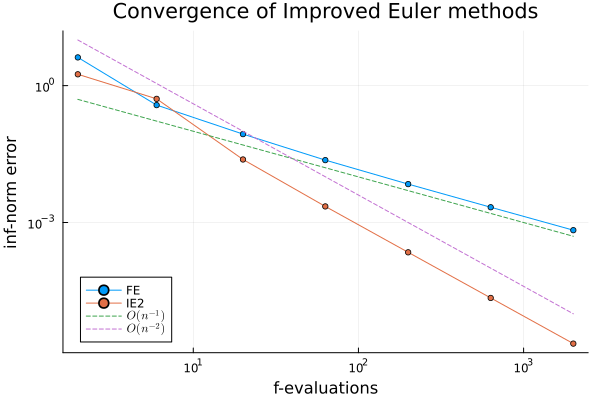

In [49]:
plot([n n],[err_FE err_IE2],m=3,label=["FE" "IE2"],
    xaxis=(:log10,"f-evaluations"),yaxis=(:log10,"inf-norm error"),
    title="Convergence of Improved Euler methods",leg=:bottomleft)

plot!(n, (n).^(-1), l=:dash, label=L"O(n^{-1})")
plot!(n,1e-5*(n/n[end]).^(-2),l=:dash,label=L"O(n^{-2})")

### 4. Modified Euler method and Heun's method
#### 4.1 Numerical Scheme
The modified Euler method is the formula
$$
\begin{split}  \begin{split}
    k_1 &= h f(t_i,u_i),\\
    k_2 &= h f(t_i+h,u_i + k_1),\\
    \mathbf{u}_{i+1} &= u_i + \frac{1}{2}k_1 + \frac{1}{2} k_2.
  \end{split}\end{split}
$$
The Heun's method is the formula
$$
\begin{split}  \begin{split}
    k_1 &= h f(t_i,u_i),\\
    k_2 &= h f(t_i+\frac{2}{3}h,u_i + \frac{2}{3}k_1),\\
    \mathbf{u}_{i+1} &= u_i + \frac{1}{4}k_1 + \frac{3}{4} k_2.
  \end{split}\end{split}
$$

#### 4.2 Implementation

In [35]:
# Implementation of Modified Euler method
"""
    me2(ivp, n)

Apply the Modified Euler method to solve the given IVP using `n`
time steps. Return a vector of times and a vector of solution
values.
"""
function me2(ivp, n)
    # Time discretization.
    a, b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]
    
    # Initialize output.
    u = fill(float(ivp.u0), n+1)
    
    # Time stepping.
    for i in 1:n
        k1 = h*ivp.f( u[i], ivp.p, t[i] );
        k2 = h*ivp.f( u[i]+k1, ivp.p, t[i]+h );
        u[i+1] = u[i] + (1/2)*k1 + (1/2)*k2;
    end
    return t, u
end



me2

In [36]:
# Implementation of Heun's method
"""
    he2(ivp, n)

Apply the Heun's method to solve the given IVP using `n`
time steps. Return a vector of times and a vector of solution
values.
"""
function he2(ivp, n)
    # Time discretization.
    a, b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]
    
    # Initialize output.
    u = fill(float(ivp.u0), n+1)
    
    # Time stepping.
    for i in 1:n
        k1 = h*ivp.f( u[i], ivp.p, t[i] );
        k2 = h*ivp.f( u[i]+(2/3)*k1, ivp.p, t[i]+(2/3)*h );
        u[i+1] = u[i] + (1/4)*k1 + (3/4)*k2;
    end
    return t, u
end

he2

#### 4.3 Example
Given the IVP
$$
u' = -2t u, \ 0 \le t \le 2, \ u(0) = 2;\  \hat{u}(t) = 2e^{-t^2}
$$
Test your function on the IVP by solving with $n=30,60,90,\ldots,300$ and plotting the convergence of the error at the final time together with a line showing $O(n^{-2})$.

In [37]:
f = ((u, p, t) -> -2*t*u);
tspan = (0.0, 2.0);
u0 = 2;

ivp = ODEProblem(f, u0, tspan)

ODEProblem with uType Int64 and tType Float64. In-place: false
timespan: (0.0, 2.0)
u0: 2

In [38]:
u_ref = (t -> 2*exp(-t^2));

In [42]:
n = [ round(Int, k*30) for k in 1:10 ];
err_ME2, err_HE2 = [], [];

for n in n
    t,u = me2(ivp,n)
    push!( err_ME2, maximum( @.abs(u_ref(t)-u) ) )
    t,u = he2(ivp,n)
    push!( err_HE2, maximum( @.abs(u_ref(t)-u) ) )
end

pretty_table([n err_ME2 err_HE2]; header=["n","ME2 error","HE2 error"])

┌─────┬─────────────┬─────────────┐
│   n │   ME2 error │   HE2 error │
├─────┼─────────────┼─────────────┤
│  30 │  0.00174318 │  0.00102237 │
│  60 │ 0.000417486 │   0.0002418 │
│  90 │ 0.000183006 │ 0.000105495 │
│ 120 │ 0.000102242 │  5.87924e-5 │
│ 150 │  6.51767e-5 │  3.74253e-5 │
│ 180 │   4.5143e-5 │  2.58964e-5 │
│ 210 │  3.31037e-5 │  1.89764e-5 │
│ 240 │  2.53089e-5 │  1.45001e-5 │
│ 270 │  1.99749e-5 │    1.144e-5 │
│ 300 │  1.61658e-5 │  9.25531e-6 │
└─────┴─────────────┴─────────────┘


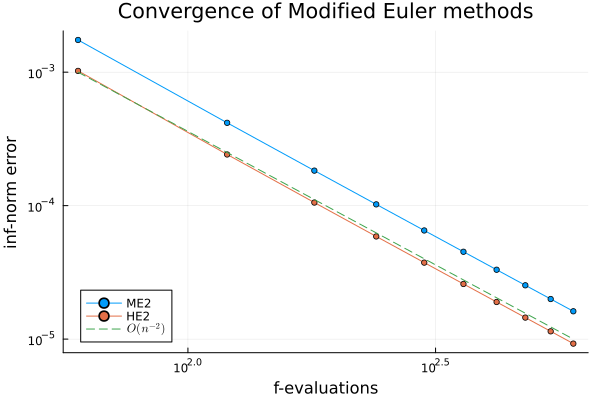

In [53]:
plot([2n 2n],[err_ME2 err_HE2],m=3,label=["ME2" "HE2"],
    xaxis=(:log10,"f-evaluations"),yaxis=(:log10,"inf-norm error"),
    title="Convergence of Modified Euler methods",leg=:bottomleft)

plot!(2n,1e-5*(n/n[end]).^(-2),l=:dash,label=L"O(n^{-2})")